In [18]:


# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [19]:

# Load Data
df = pd.read_csv('Weekly.csv', parse_dates=['week'])
df.sort_values('week', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


In [20]:


# Data Preparation
# Fill missing values
df.fillna(0, inplace=True)

# Log transform big features to reduce skewness
df['log_revenue'] = np.log1p(df['revenue'])
for col in ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']:
    df[f'log_{col}'] = np.log1p(df[col])

# Optional: scale features
features = ['log_facebook_spend', 'log_google_spend', 'log_tiktok_spend',
            'log_instagram_spend', 'log_snapchat_spend', 'social_followers',
            'average_price', 'promotions', 'emails_send', 'sms_send']
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)
df_scaled['log_revenue'] = df['log_revenue']

In [21]:


# Mediator Handling (Google)
# Two-stage approach:
# Stage 1: Predict Google spend from social spends
X_social = df_scaled[['log_facebook_spend','log_tiktok_spend','log_instagram_spend','log_snapchat_spend']]
y_google = df_scaled['log_google_spend']
model_stage1 = Ridge(alpha=1.0)
model_stage1.fit(X_social, y_google)
df_scaled['google_pred'] = model_stage1.predict(X_social)

# Stage 2: Predict revenue using predicted Google + other features
X_stage2 = df_scaled[['google_pred', 'log_facebook_spend','log_tiktok_spend','log_instagram_spend','log_snapchat_spend',
                      'social_followers','average_price','promotions','emails_send','sms_send']]
y_stage2 = df_scaled['log_revenue']

# Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=5)
model_stage2 = Ridge(alpha=1.0)
scores = cross_val_score(model_stage2, X_stage2, y_stage2, cv=tscv, scoring='r2')
print("Time-series CV R2 scores:", scores)
print("Mean R2:", np.mean(scores))

# Fit final model
model_stage2.fit(X_stage2, y_stage2)

Time-series CV R2 scores: [-0.6801487   0.67269578  0.50594235  0.88232286  0.41371393]
Mean R2: 0.3589052426575671


Ridge()

RMSE: 1.8484811296733177 R2: 0.6677120160971366


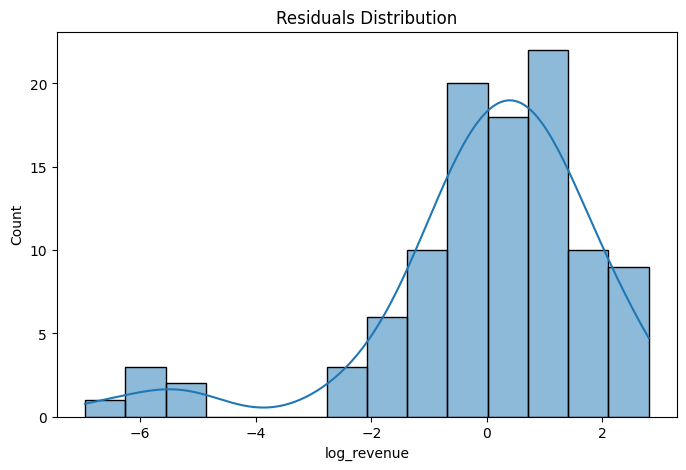

In [22]:


# Diagnostics
y_pred = model_stage2.predict(X_stage2)
rmse = np.sqrt(mean_squared_error(y_stage2, y_pred))
r2 = r2_score(y_stage2, y_pred)
print("RMSE:", rmse, "R2:", r2)

# Residual Plot
residuals = y_stage2 - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()


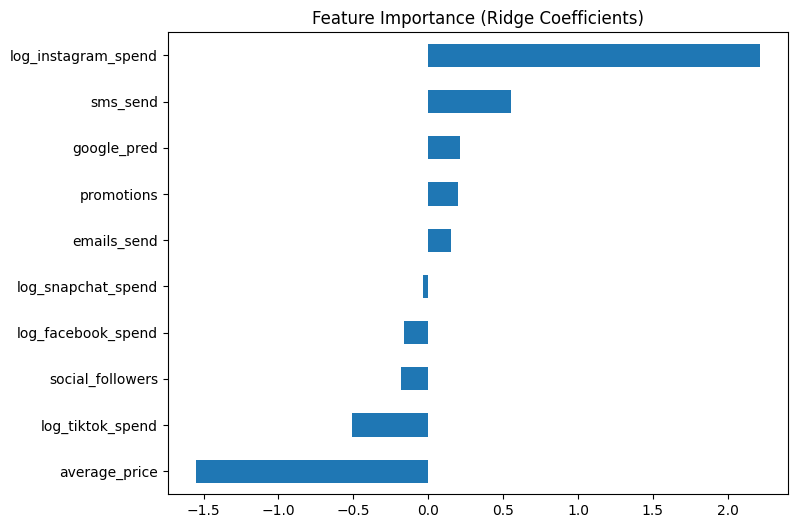

In [23]:

# Feature Importance
coefs = pd.Series(model_stage2.coef_, index=X_stage2.columns)
coefs.sort_values().plot(kind='barh', figsize=(8,6), title='Feature Importance (Ridge Coefficients)')
plt.show()


In [24]:

# Insights
print("Top positive drivers of revenue:", coefs.sort_values(ascending=False).head(5))
print("Top negative drivers of revenue:", coefs.sort_values().head(5))



Top positive drivers of revenue: log_instagram_spend    2.212575
sms_send               0.551370
google_pred            0.215037
promotions             0.198317
emails_send            0.149349
dtype: float64
Top negative drivers of revenue: average_price        -1.551261
log_tiktok_spend     -0.510736
social_followers     -0.178621
log_facebook_spend   -0.158358
log_snapchat_spend   -0.032914
dtype: float64


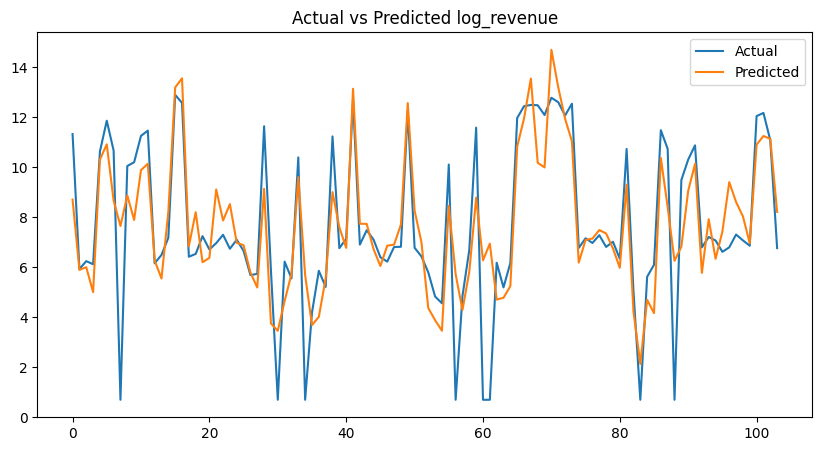

In [25]:
plt.figure(figsize=(10,5))
plt.plot(y_stage2.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted log_revenue')
plt.show()

In [26]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Evaluate model performance
r2 = r2_score(y_stage2, y_pred)
rmse = np.sqrt(mean_squared_error(y_stage2, y_pred))
mae = mean_absolute_error(y_stage2, y_pred)

print("R² (explained variance):", round(r2, 3))
print("RMSE (root mean squared error):", round(rmse, 3))
print("MAE (mean absolute error):", round(mae, 3))


R² (explained variance): 0.668
RMSE (root mean squared error): 1.848
MAE (mean absolute error): 1.293
